In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 24 21:52:30 2018

@author: whitneyreiner
"""
#Import packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import numpy as np
import pandas as pd, matplotlib.pyplot as plt, time
import seaborn as sns
import hdbscan
from numpy import arccos, arcsin, around, cos, pi, radians, sin
#delete if runs without!
#from sklearn.cluster import DBSCAN
#from geopy.distance import great_circle
#from shapely.geometry import MultiPoint
#from datetime import datetime as dt

%matplotlib inline

# Set your postgres username
dbname = 'postgres'
username = 'whitneyreiner' # change this to your username

# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)
## 'engine' is a connection to a database
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

# query:
sql_query = """
SELECT * FROM import.ladataset201678 WHERE issueyear='2018'
LIMIT 100000;
"""
tickets_table_from_sql = pd.read_sql_query(sql_query,con)
tickets_table_from_sql.head()

postgres://whitneyreiner@localhost/postgres


,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour
0,4322863020,TOYT,PA,GY,7860 SUNSET BL,00486,54.0,88.13B+,METER EXP.,63.0,14:23:00,2018-01-03 14:23:00,2018-01-03,2018,2,1,34.098066000665156,-118.36072228438765,14
1,4322863031,MERZ,PA,BK,550 WESTERN AV N,00486,54.0,88.13B+,METER EXP.,63.0,16:41:00,2018-01-03 16:41:00,2018-01-03,2018,2,1,34.064404490171995,-118.30909642966827,16
2,4322863042,CHRY,PA,BK,3001 W LONDON ST,00421,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:14:00,2018-01-05 08:14:00,2018-01-05,2018,4,1,34.077603001312774,-118.27968100094856,8
3,4322863053,NISS,PA,WT,3001 W LONDON ST,00421,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:15:00,2018-01-05 08:15:00,2018-01-05,2018,4,1,34.077603001312774,-118.27968100094856,8
4,4322863064,NISS,PA,GO,401 N PARKMAN AVE,00421,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:18:00,2018-01-05 08:18:00,2018-01-05,2018,4,1,34.076193000504425,-118.27707000010379,8


In [6]:
tickets_table_from_sql['newlat'] = pd.to_numeric(tickets_table_from_sql['newlat'])
tickets_table_from_sql['newlong'] = pd.to_numeric(tickets_table_from_sql['newlong'])
tickets_table_from_sql['dt_issuednew'] = pd.to_datetime(tickets_table_from_sql['dt_issuednew'])
tickets_table_from_sql = tickets_table_from_sql[~tickets_table_from_sql['newlat'].isnull()] 
tickets_table_from_sql[['newlat','newlong']].isnull().sum()

newlat     0
newlong    0
dtype: int64

In [103]:
#training sample
#sample1= first 100k records in sql db from 2018
sample1=tickets_table_from_sql
sample1Coords = sample1[['newlat', 'newlong']]

In [133]:
#how to validate min cluster size?
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=175, min_samples=2)
clusterer.fit(np.radians(sample1Coords))
clusterer.labels_

array([75, 75, 75, ..., -1, -1, -1])

In [168]:
clusterer.labels_.max()

161

In [167]:
clusterer.probabilities_

array([1., 1., 1., ..., 0., 0., 0.])

In [136]:
clusterer_labels = pd.DataFrame({'Cluster_no':clusterer.labels_})
clusterer_probabilities = pd.DataFrame({'Cluster_p':clusterer.probabilities_})
dfclust = pd.concat([sample1, clusterer_labels, clusterer_probabilities], axis=1)
#save to csv
#-# dfclust.to_csv('dfhdbscanclusterlabels_probs.csv', index=False, encoding='utf-8')

,newlat,newlong,Cluster_no,Cluster_p
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,34.072366,-118.347712,60.731560,0.673077
std,0.078158,0.089934,54.150073,0.425794
min,33.706320,-118.647191,-1.000000,0.000000
25%,34.039748,-118.424732,-1.000000,0.000000
50%,34.062255,-118.336786,56.000000,0.957562
75%,34.102461,-118.276102,109.000000,1.000000
max,34.328338,-118.160250,161.000000,1.000000


In [99]:
#HDBSCAN
datacoor = dfclust[['newlat', 'newlong']].values
data = np.radians(datacoor)
#16 newlat
#17 newlong
#19 cluster_no
#20 cluster_p
datacoor

array([[  33.994238  , -118.47745533],
       [  33.994719  , -118.477838  ],
       [  33.993662  , -118.476997  ],
       ...,
       [  34.186638  , -118.485828  ],
       [  34.186638  , -118.485828  ],
       [  34.2020849 , -118.44875898]])

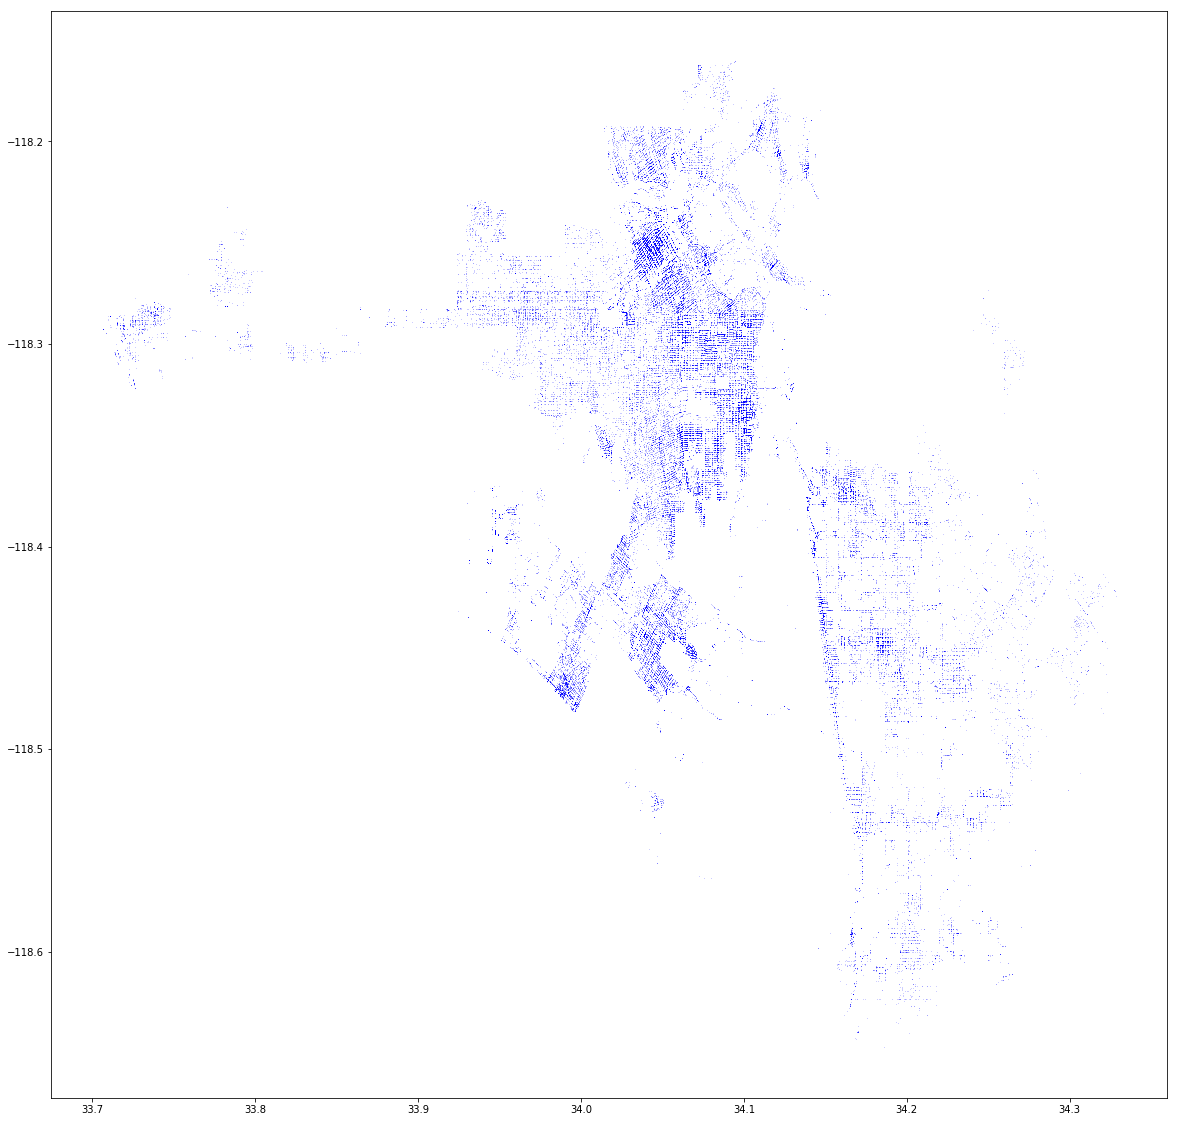

In [100]:
#-# fig, ax = plt.subplots(figsize=[20, 20])
#-# plt.scatter(*datacoor.T, s=1, linewidth=0, c='b', alpha=0.25)

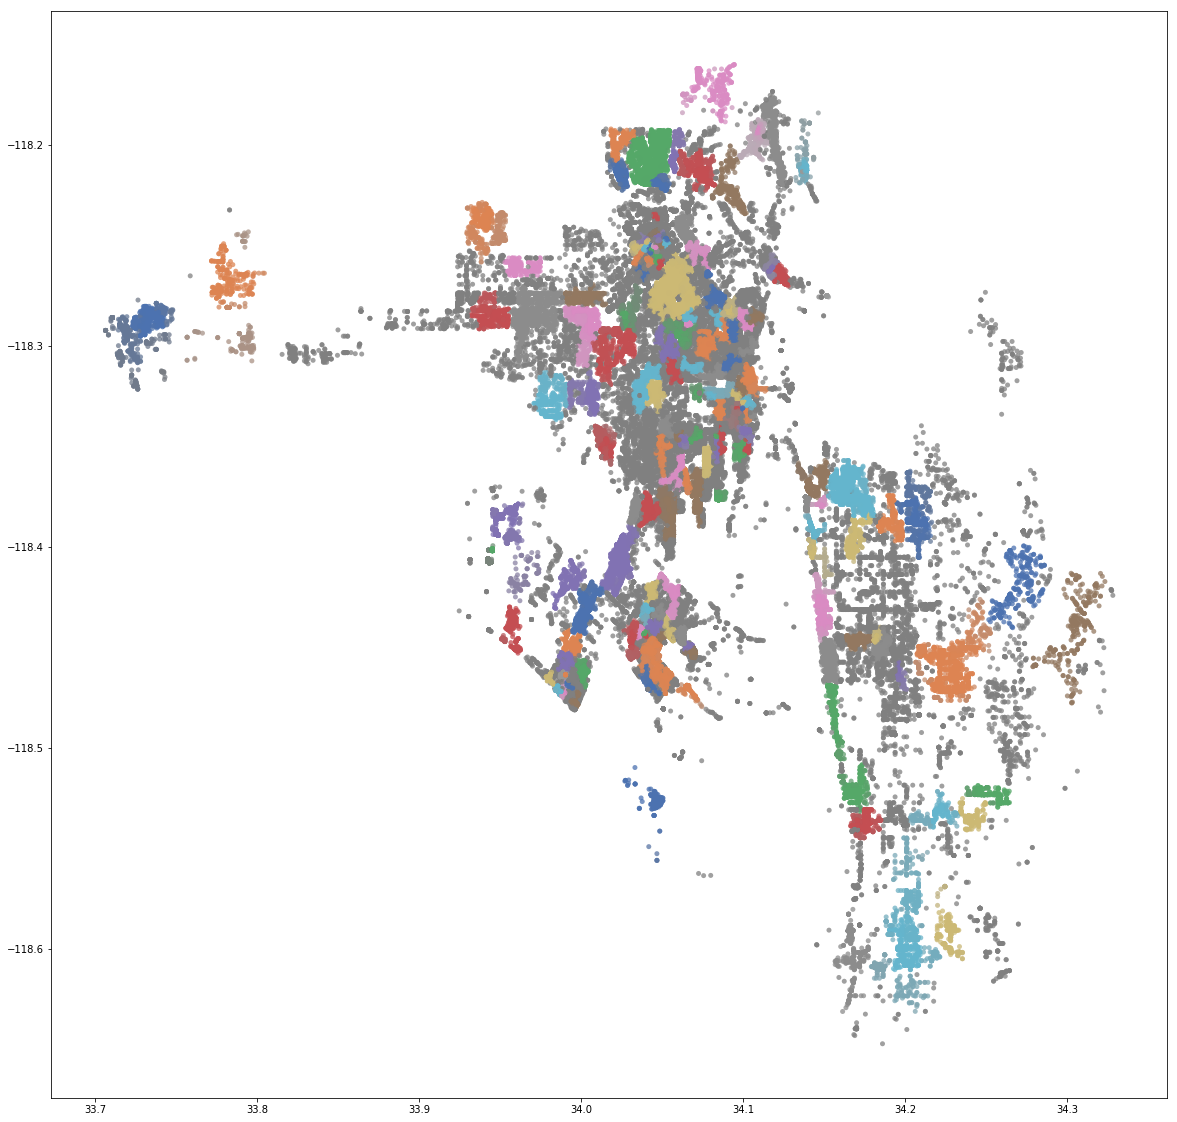

In [165]:
#-# clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=175, min_samples=1)
#-# clusterer.fit(np.radians(sample1Coords))

#-# color_palette = sns.color_palette('deep', 215)
#-# cluster_colors = [color_palette[x] if x >= 0
#-#                   else (0.5, 0.5, 0.5)
#-#                   for x in clusterer.labels_]
#-# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#-#                          zip(cluster_colors, clusterer.probabilities_)]
#-# fig, ax = plt.subplots(figsize=[20, 20])
#-# plt.scatter(*datacoor.T, s=25, linewidth=0, c=cluster_member_colors, alpha=0.75)

In [287]:
#extract the clusters
#sns.set_context('poster')
#-# sns.set_style('white')
#-# sns.set_color_codes()
#-# plot_kwds = {'alpha' : 0.5, 's' : 25, 'linewidths':0}

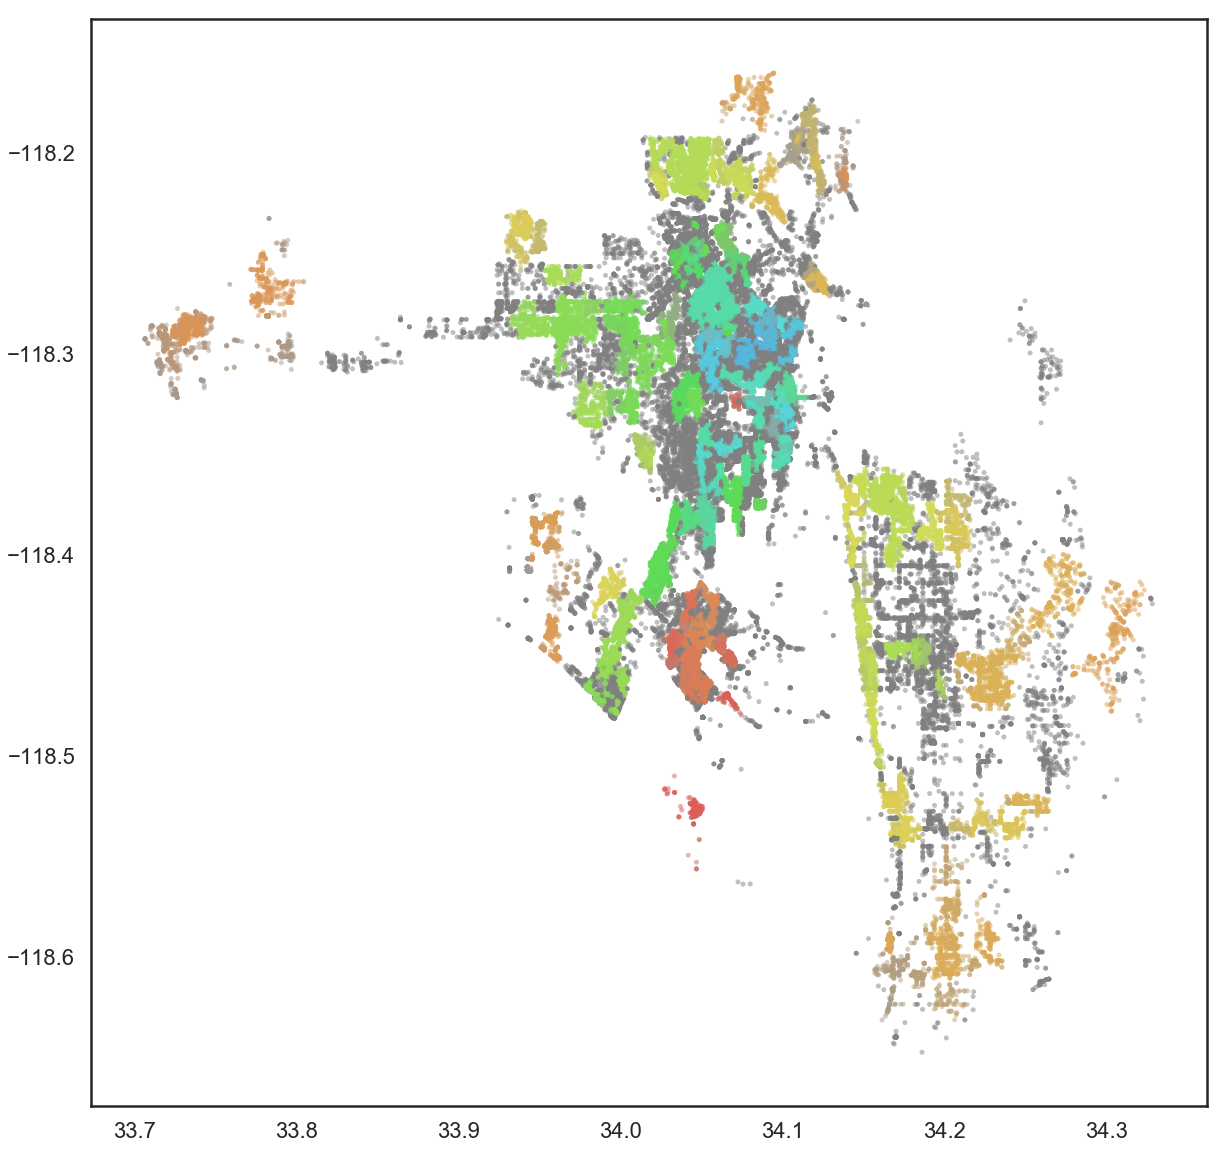

In [284]:
#clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=175, min_samples=1)
#clusterer.fit(np.radians(sample1Coords))

#-# palette = sns.color_palette("hls", 300)
#-# cluster_colors = [sns.desaturate(palette[col], sat)
#-#                   if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
#-#                   zip(clusterer.labels_, clusterer.probabilities_)]
#-# fig, ax = plt.subplots(figsize=[20, 20])
#-# plt.scatter(datacoor.T[0], datacoor.T[1], c=cluster_colors, **plot_kwds)

In [ ]:
#Predicting new data
#Use a test set- 35 from 2018

In [225]:
# query for test set:
sql_query = """
SELECT *
FROM import.ladataset201678
WHERE issueyear='2018'
OFFSET 100000 ROWS
FETCH NEXT 100 ROWS ONLY
;

"""

testset_table_from_sql = pd.read_sql_query(sql_query,con)
#-# testset_table_from_sql.head()

,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour
0,4337939222,AUDI,PA,GY,11668 KIOWA AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,09:12:00,2018-08-17 09:12:00,2018-08-17,2018,4,8,34.05147588720136,-118.46201245804941,9
1,4337939233,AUDI,PA,GY,11668 KIOWA AVE,00143,51.0,5200,DISPLAY OF PLATES,25.0,09:12:00,2018-08-17 09:12:00,2018-08-17,2018,4,8,34.05147588720136,-118.46201245804941,9
2,4337939244,VOLK,PA,WT,1155 BARRY AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,09:15:00,2018-08-17 09:15:00,2018-08-17,2018,4,8,34.05118490698054,-118.46051505292948,9
3,4337939255,KIA,PA,SL,1900 CENTINELA AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,12:04:00,2018-08-17 12:04:00,2018-08-17,2018,4,8,34.03165699810951,-118.45761499936424,12
4,4337940596,TOYT,PA,BL,7500 VISTA DEL MAR,504A,51.0,80.69B,NO PARKING,73.0,00:21:00,2018-08-17 00:21:00,2018-08-17,2018,4,8,33.95297200030754,-118.44716799317352,0


In [226]:
#-# testset_table_from_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
ticketnumber            100 non-null object
make                    100 non-null object
bodystyle               100 non-null object
color                   100 non-null object
location                100 non-null object
route                   100 non-null object
agency                  100 non-null object
violationcode           100 non-null object
violationdescription    100 non-null object
fineamount              100 non-null object
issuetime               100 non-null object
dt_issuednew            100 non-null object
issuedatenew            100 non-null object
issueyear               100 non-null object
weekday                 100 non-null object
month                   100 non-null object
newlat                  100 non-null object
newlong                 100 non-null object
hour                    100 non-null object
dtypes: object(19)
memory usage: 14.9+ KB


In [227]:
#double check to make sure you queried correctly by looking for one of the ticket 
# numberss in this table in the training data table:
#-# '4333387973' in tickets_table_from_sql.ticketnumber.values

False

In [228]:
testset_table_from_sql['newlat'] = pd.to_numeric(testset_table_from_sql['newlat'])
testset_table_from_sql['newlong'] = pd.to_numeric(testset_table_from_sql['newlong'])
testset_table_from_sql['dt_issuednew'] = pd.to_datetime(testset_table_from_sql['dt_issuednew'])
testset_table_from_sql = testset_table_from_sql[~testset_table_from_sql['newlat'].isnull()] 
#-# testset_table_from_sql[['newlat','newlong']].isnull().sum()

newlat     0
newlong    0
dtype: int64

In [229]:
#test sample
#testsample=  35 records in sql db from 2018 STARTING AFTER record 100000 
testsample=testset_table_from_sql
testsampleCoords = testsample[['newlat', 'newlong']]

In [263]:
#training data = datacoor

In [252]:
test_points_coords = testsampleCoords.values
#-# test_points_coords.shape

(100, 2)

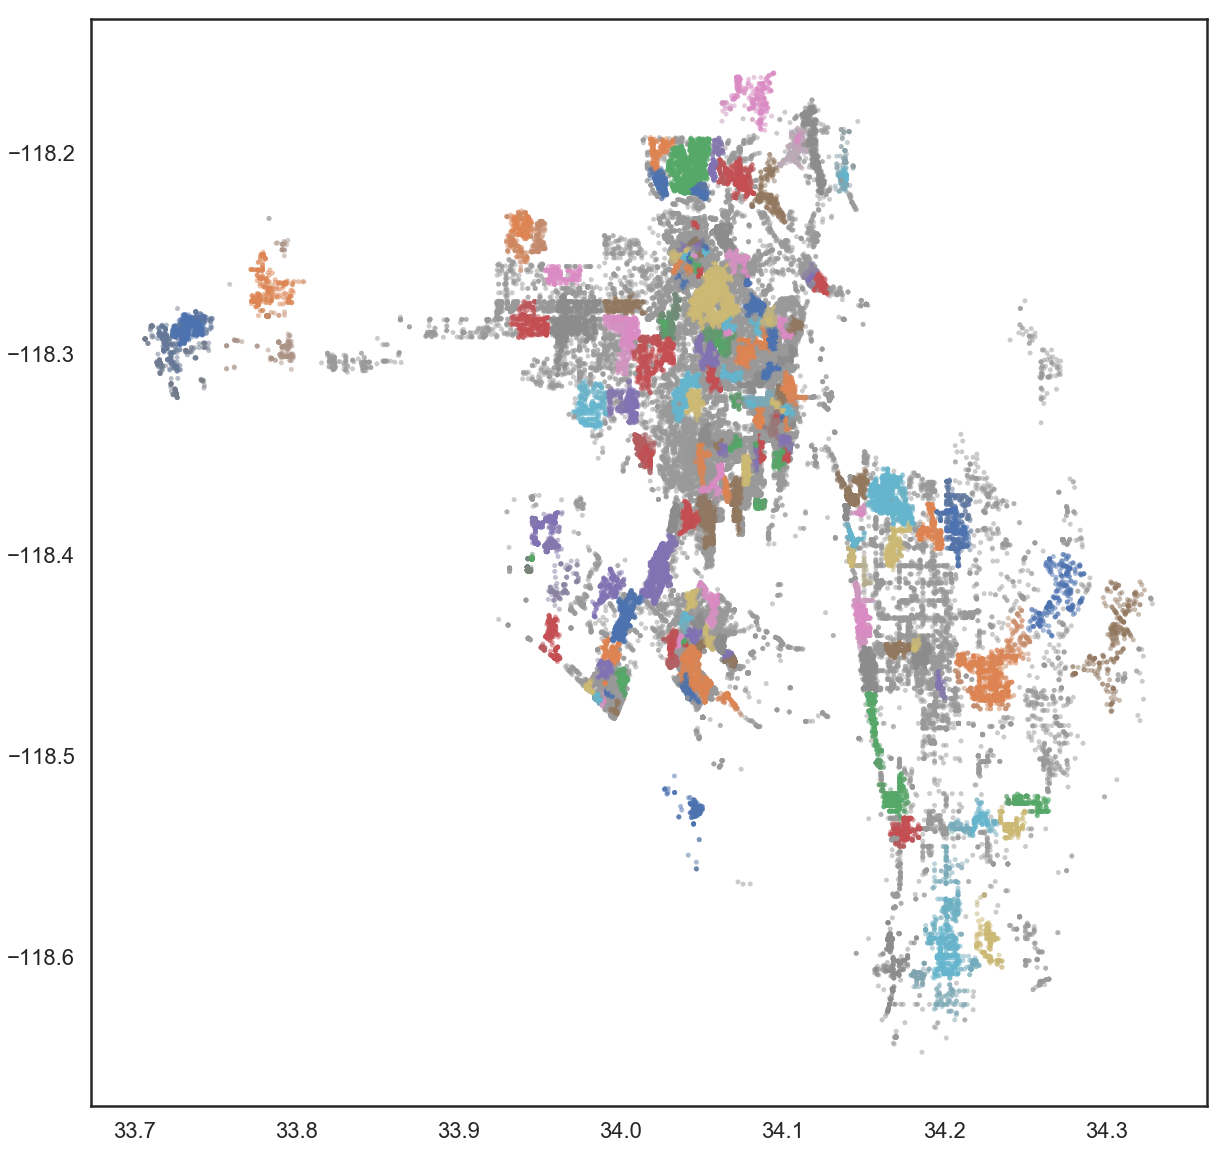

In [285]:
#set it up so it knows it is prediciton data
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=175, min_samples=2,prediction_data=True)
clusterer.fit(np.radians(sample1Coords))
pal = sns.color_palette('deep', 300)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
fig, ax = plt.subplots(figsize=[20, 20])
plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);

In [238]:
#check the size 
#-# test_points_coords.shape

(100, 2)

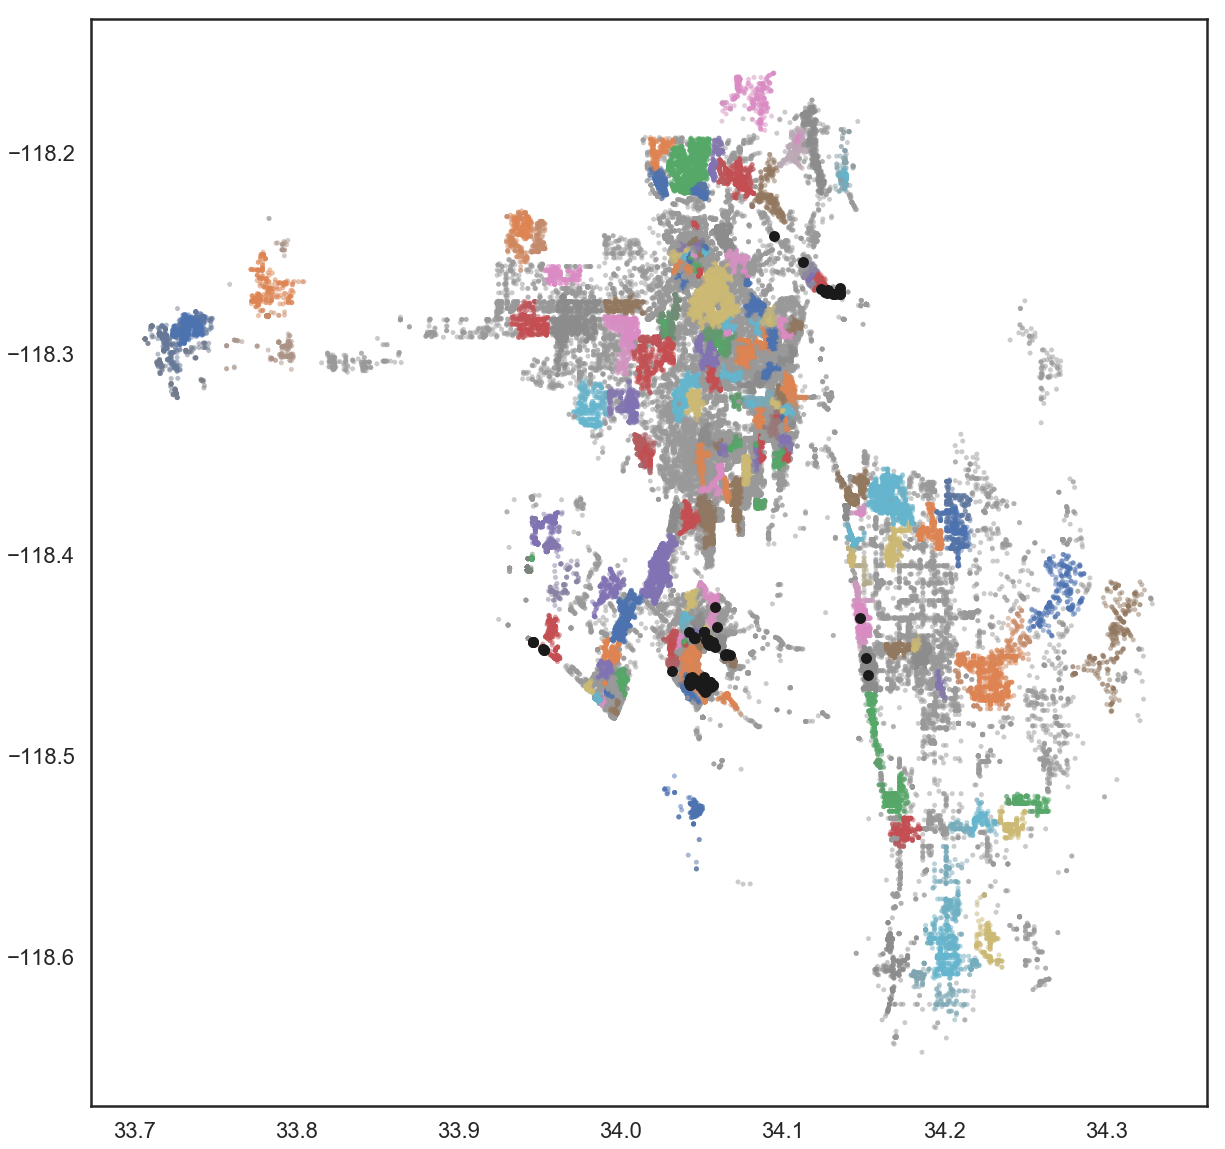

In [288]:
# MAKE SURE YOU ARE PLOTTING BOTH AS RADS OR BOTH AS COORDINATES!!!! OR IT WILL FUCK UP
#-# test_points = np.radians(test_points_coords)
#-# fig, ax = plt.subplots(figsize=[20, 20])
#-# colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
#plt.ylim(-2.072, -2.060)                                                           
#plt.xlim(0.586, 0.601)
#-# plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);
#-# plt.scatter(*test_points_coords.T, c='k', s=80)

In [254]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
test_labels

array([11, 11, -1, -1, 23, 23, -1, -1, -1, 23, 14, 18, 18, 18, 18, 18, 18,
        4, -1, 16, 18, 18, -1, 18,  4,  4,  4, 18, 18, 18, 18, 18, 18, 18,
       18, 14, 14, 14, 33, 33, 33, 33, 33, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, 57, 57, 56, 11, -1, -1, 11, 11, 11, 11, 11, 11, 11, -1, -1,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [259]:
#-# test_labelsdf = pd.DataFrame({'test_clust_no': test_labels})
#-# test_labelsdf.head()

,test_clust_no
0,11
1,11
2,-1
3,-1
4,23


In [268]:
#-# testSet_dfclust = pd.concat([testsample, test_labelsdf], axis=1)
#-# testSet_dfclust.describe()
#-# testSet_dfclust.head()
#save as csv

,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour,test_clust_no
0,4337939222,AUDI,PA,GY,11668 KIOWA AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,09:12:00,2018-08-17 09:12:00,2018-08-17,2018,4,8,34.051476,-118.462012,9,11
1,4337939233,AUDI,PA,GY,11668 KIOWA AVE,00143,51.0,5200,DISPLAY OF PLATES,25.0,09:12:00,2018-08-17 09:12:00,2018-08-17,2018,4,8,34.051476,-118.462012,9,11
2,4337939244,VOLK,PA,WT,1155 BARRY AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,09:15:00,2018-08-17 09:15:00,2018-08-17,2018,4,8,34.051185,-118.460515,9,-1
3,4337939255,KIA,PA,SL,1900 CENTINELA AVE,00143,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,12:04:00,2018-08-17 12:04:00,2018-08-17,2018,4,8,34.031657,-118.457615,12,-1
4,4337940596,TOYT,PA,BL,7500 VISTA DEL MAR,504A,51.0,80.69B,NO PARKING,73.0,00:21:00,2018-08-17 00:21:00,2018-08-17,2018,4,8,33.952972,-118.447168,0,23


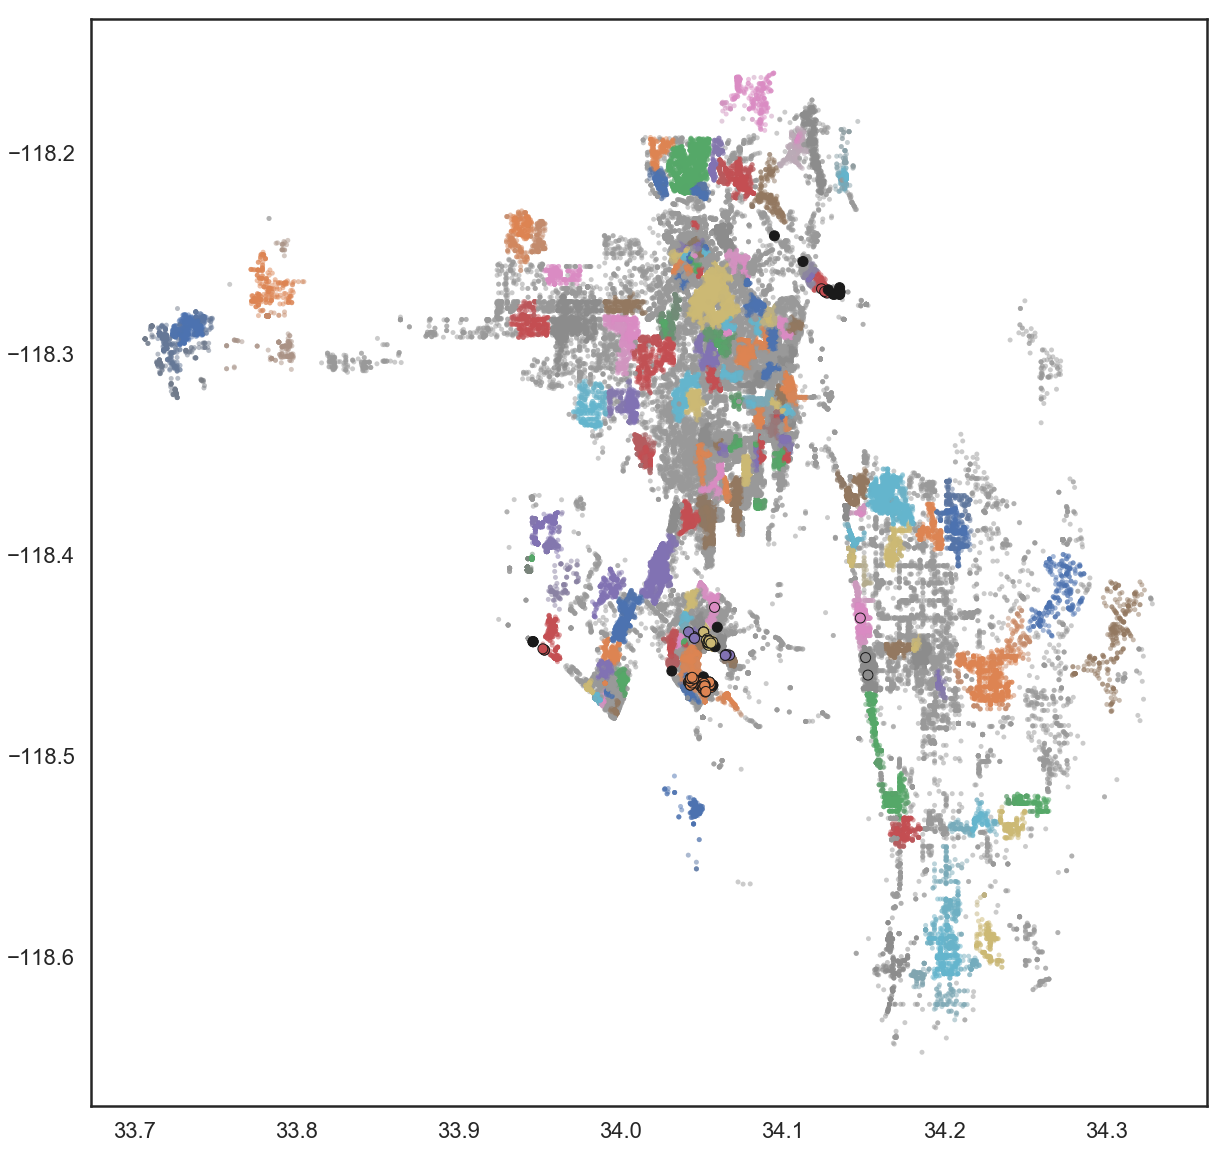

In [290]:
# MAKE SURE YOU ARE PLOTTING BOTH AS RADS OR BOTH AS COORDINATES!!!! OR IT WILL FUCK UP
#-# fig, ax = plt.subplots(figsize=[20, 20])

#-# colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
#-# test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
#-# plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);
#-# plt.scatter(*test_points_coords.T, c=test_colors, s=100, linewidths=1, edgecolors='k')